# AM207 Final Report

# Abstract

<hr/>

# Introduction

<hr/>

# Related Work

<hr/>

# Method

## Variable Selection

<hr/>

## Model Building

## Metropolis-Hastings Algorithm

In [74]:
### Libraries

import matplotlib, matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import pymc

% matplotlib inline

In [246]:
### Custom Modules
import bayes_lr
import game_predictions

In [250]:
### Reloading Examples
bayes_lr = reload(bayes_lr)
game_predictions = reload(game_predictions)

In [77]:
### Settings

# Games path.
games_path = 'games_2015_tournament.csv'
priors_path = 'Priors.csv'

## Data

In [78]:
# Read games.
games = pd.read_csv(games_path)
# Trim to single group.
games = games[games.game_group == 1].reset_index(drop=True)
# 2015 games.
games_2015 = games[games.ncaa_tournament == 0].reset_index(drop=True)
# 2015 NCAA tournament games
games_2015_ncaa = games[games.ncaa_tournament == 1].reset_index(drop=True)

In [79]:
games_2015

,game_id,game_group,year,date,team,opponent,conference,conference_tournament,ncaa_tournament,other_tournament,...,ratio_RankAdjOE,ratio_RankAdjTempo,ratio_RankDE,ratio_RankOE,ratio_RankPythag,ratio_RankTempo,ratio_Tempo,points_for,points_against,win
0,20141114-airforce-army,1,2015,2014-11-14,Army,Air Force,0,0,0,0,...,3.034091,0.036184,0.782456,1.847826,1.290640,0.060790,1.134062,84,78,1
1,20141114-akron-umbc,1,2015,2014-11-14,Akron,UMBC,0,0,0,0,...,0.450867,1.445860,0.361502,0.368876,0.267442,0.948718,1.002438,74,57,1
2,20141114-alabama-towson,1,2015,2014-11-14,Towson,Alabama,0,0,0,0,...,4.033333,1.104377,1.552147,2.116505,4.344262,1.154122,0.974324,54,82,0
3,20141114-alabamaam-dayton,1,2015,2014-11-14,Alabama A&M,Dayton,0,0,0,0,...,4.191781,1.102804,11.333333,3.236559,8.250000,0.994975,1.000082,52,76,0
4,20141114-alcornst-california,1,2015,2014-11-14,Alcorn St.,California,0,0,0,0,...,1.790055,0.584906,2.294964,1.366379,2.982759,0.533981,1.020971,57,91,0
5,20141114-american-temple,1,2015,2014-11-14,American,Temple,0,0,0,0,...,1.092486,2.845528,10.200000,0.809322,3.321429,2.264516,0.876852,37,40,0
6,20141114-arizona-mountstmarys,1,2015,2014-11-14,Arizona,Mount St. Mary's,0,0,0,0,...,0.039286,0.287823,0.029412,0.065134,0.008929,0.298507,1.059393,78,55,1
7,20141114-arizonast-chicagost,1,2015,2014-11-14,Arizona St.,Chicago St.,0,0,0,0,...,0.200000,0.421053,0.403704,0.411594,0.208333,0.455939,1.044194,86,50,1
8,20141114-arkansaspinebluff-hawaii,1,2015,2014-11-14,Hawaii,Arkansas Pine Bluff,0,0,0,0,...,0.456456,0.067961,0.492063,0.433735,0.376543,0.120879,1.068176,85,57,1
9,20141114-auburn-milwaukee,1,2015,2014-11-14,Milwaukee,Auburn,0,0,0,0,...,1.398551,4.352941,1.139442,0.859922,1.408451,2.473684,0.967571,73,83,0


## Model

In [84]:
# Features.
features = ['diff_Pythag','diff_AdjOE','diff_AdjDE','location_Away','diff_RankAdjDE']

In [85]:
priors = pd.read_csv(priors_path)
priors.head()

,Unnamed: 0,Estimate,Std. Error,z value,Pr(>|z|)
0,(Intercept),0.495515,0.045759,10.828880,2.512097e-27
1,diff_Pythag,1.418366,1.025396,1.383237,1.665922e-01
2,diff_AdjOE,0.114664,0.023133,4.956645,7.172097e-07
3,diff_AdjDE,-0.141281,0.025689,-5.499668,3.805078e-08
4,location_Away,-1.054997,0.069461,-15.188397,4.221181e-52


In [86]:
# Priors
coef_dist_params = []
b0_params={'mu':priors.iloc[0][1], 'tau':priors.iloc[0][2], 'value':0}
for i in range(1,len(features)+1):
    coef_dist_params.append({'mu':priors.iloc[i][1], 'tau':priors.iloc[i][2], 'value':0})
coef_dist_params

[{'mu': 1.4183656505726498, 'tau': 1.0253959708593698, 'value': 0},
 {'mu': 0.11466422117814901, 'tau': 0.023133435813736, 'value': 0},
 {'mu': -0.14128114425290603, 'tau': 0.025689033067794, 'value': 0},
 {'mu': -1.0549970470677299, 'tau': 0.0694607248258996, 'value': 0},
 {'mu': 0.0015390113213159199, 'tau': 0.0014444674432672901, 'value': 0}]

In [102]:
# Priors
coef_dist_params = []
b0_params={'mu':priors.iloc[0][1], 'tau':10, 'value':0}
for i in range(1,len(features)+1):
    coef_dist_params.append({'mu':priors.iloc[i][1], 'tau':10, 'value':0})
# coef_dist_params[2] = {'mu': 0, 'tau': 3, 'value': 0}
# coef_dist_params[3] = {'mu': 0, 'tau': 3, 'value': 0}

coef_dist_params

[{'mu': 1.4183656505726498, 'tau': 10, 'value': 0},
 {'mu': 0.11466422117814901, 'tau': 10, 'value': 0},
 {'mu': -0.14128114425290603, 'tau': 10, 'value': 0},
 {'mu': -1.0549970470677299, 'tau': 10, 'value': 0},
 {'mu': 0.0015390113213159199, 'tau': 10, 'value': 0}]

In [103]:
model_mcmc = bayes_lr.model_games(data=games_2015,features=features,b0_params=b0_params,coef_dist_params=coef_dist_params)

In [139]:
model_mcmc.sample(105000,5000, thin=10)

 [-----------------100%-----------------] 105000 of 105000 complete in 161.1 sec

## Diagnostics

Plotting b_diff_RankPythag
Plotting b_diff_RankAdjTempo
Plotting b_0
Plotting b_diff_DE
Plotting err
Plotting b_location_Home
Plotting b_diff_OE


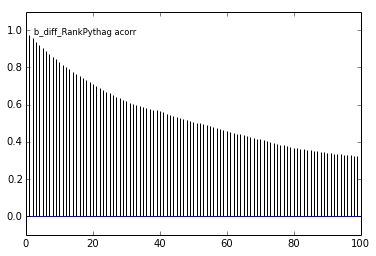

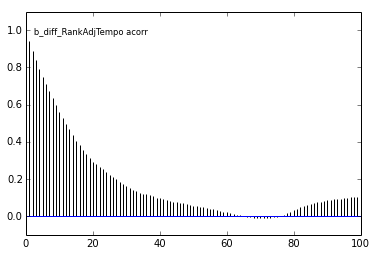

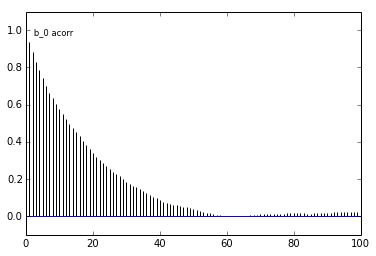

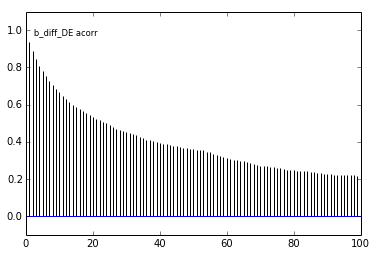

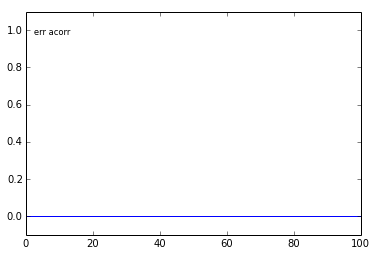

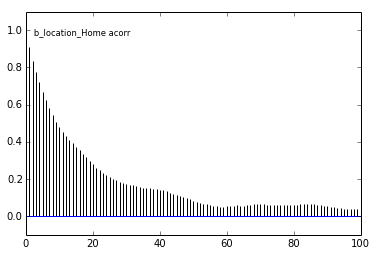

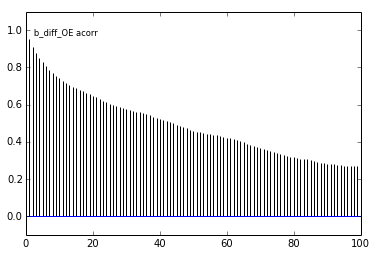

In [11]:
# No thinning
pymc.Matplot.autocorrelation(model_mcmc)

Plotting b_diff_AdjOE
Plotting b_diff_Pythag
Plotting b_diff_RankAdjDE
Plotting b_diff_AdjDE
Plotting err
Plotting b_location_Away
Plotting b_0


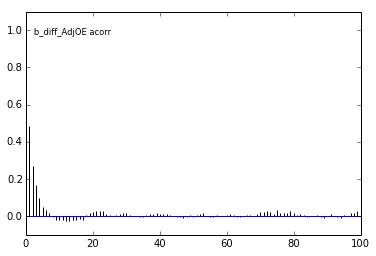

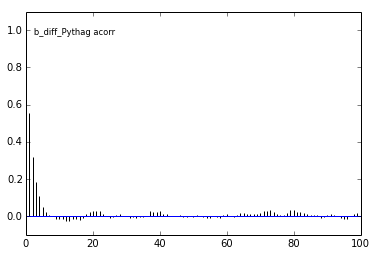

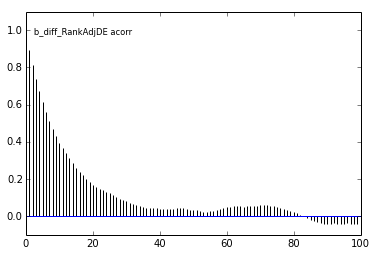

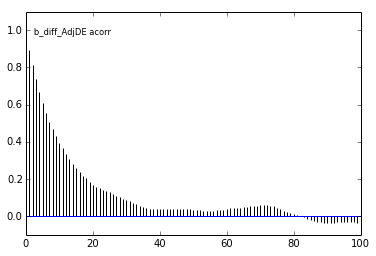

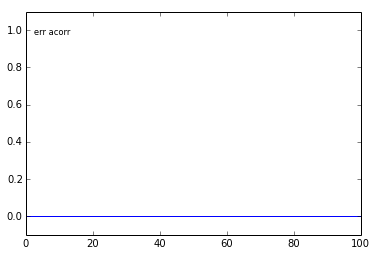

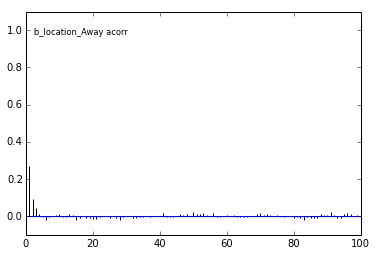

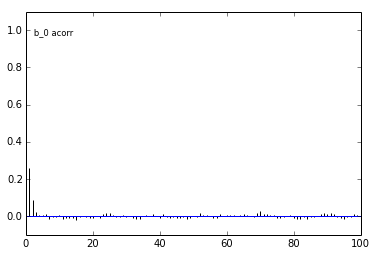

In [163]:
# With Thinning
pymc.Matplot.autocorrelation(model_mcmc)

diff_Pythag
diff_AdjOE
diff_AdjDE
location_Away
diff_RankAdjDE


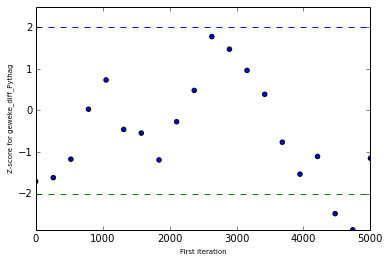

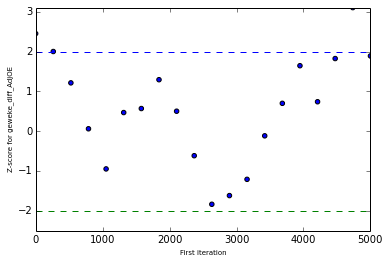

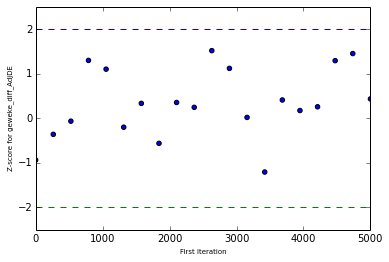

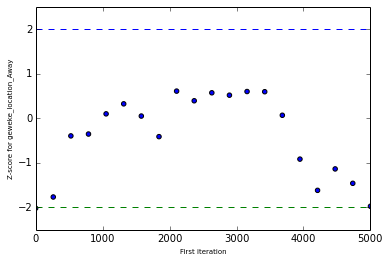

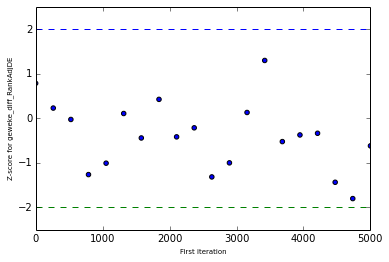

In [164]:
# Geweke Test
for feature in features:
    print feature
    scores = pymc.geweke(model_mcmc.trace('b_'+feature)[:])
    pymc.Matplot.geweke_plot(scores, name = 'geweke_'+feature)

In [252]:
geweke_scores = bayes_lr.geweke_statistics(model_mcmc,features)

diff_Pythag
diff_AdjOE
diff_AdjDE
location_Away
diff_RankAdjDE


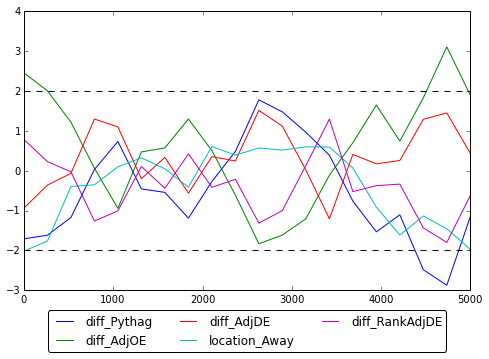

In [253]:
bayes_lr.plot_Geweke(geweke_scores, features)

In [245]:
# Display means and standard deviation
# Coefficient, Mean, Standard Deviation
model_means = bayes_lr.mcmc_trace_means(model_mcmc, [str(0)]+ features, printMeans = True)

b_0 0.471805285536 0.0455916975225
b_diff_Pythag 1.12832576256 0.301363911592
b_diff_AdjOE 0.119028764371 0.00847965608605
b_diff_AdjDE -0.118342832331 0.0244586991776
b_location_Away -1.12138536422 0.0687945843362
b_diff_RankAdjDE 0.000345079539534 0.00142574907166


## Slice Sampling

# Discussion

# Conclusion